# EhV: unsupervised analysis of reduced spec channels

# Package imports

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%matplotlib inline

In [89]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [90]:
import copy
import pickle

In [91]:
import numpy
import scipy.stats
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, robust_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale, power_transform, normalize
from sklearn.inspection import permutation_importance

import scipy.stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

import umap
import umap.plot

from matplotlib.colors import Normalize
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

from kneed import KneeLocator

In [92]:
from ehv.core import plot_gate_zarr_channels, SelectFromCollection
from ehv import normalization

In [93]:
import shap
shap.initjs()

In [94]:
import scanpy
import anndata

# Data import

In [112]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [179]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

cols = numpy.load(data_dir / "indices/columns_batch_v2.npy", allow_pickle=True)
cols = numpy.delete(cols, numpy.where(numpy.char.find(cols.astype("str"),"logicle")!=-1))
df = df[cols]

df = df.loc[numpy.load(data_dir / "indices/index_batch_v2.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(44384, 886)

In [227]:
adata = anndata.AnnData(
    df.filter(regex="feat"), 
    obs=pandas.concat([df.filter(regex="meta"), df.index.to_frame()], axis=1),
    dtype=numpy.float32
)
adata.raw = adata

In [228]:
adata.X = adata.to_df().fillna(0)

In [229]:
adata.X.shape

(44384, 872)

# Feature clustering

In [231]:
keep = adata.to_df().drop(columns=adata.var.T.filter(regex="euler")).filter(regex="feat_.*(BF1|BF2|SSC|DAPI|combined)$").columns

In [249]:
%%time
corr = scipy.stats.spearmanr(adata[:, keep].X).correlation

CPU times: user 4.38 s, sys: 564 ms, total: 4.94 s
Wall time: 8.84 s


In [250]:
# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
numpy.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - numpy.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

In [251]:
clusters = fcluster(dist_linkage, 0.1, criterion="distance").ravel().tolist()
indices = [clusters.index(c) for c in numpy.unique(clusters)]
features = [adata[:, keep].var_names[i] for i in indices]

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


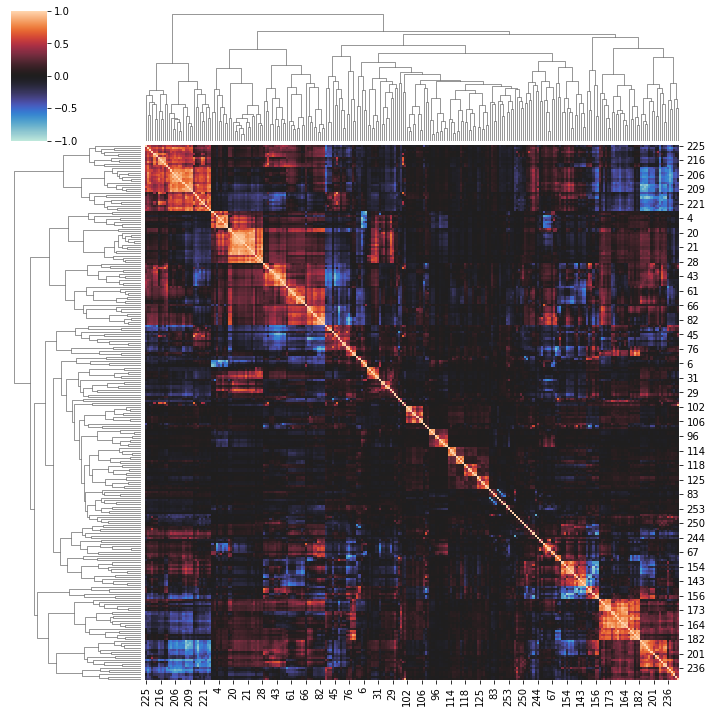

In [252]:
seaborn.clustermap(corr[indices, :][:, indices], vmin=-1, vmax=1, center=0)

In [255]:
adata.var["selected_corr"] = False
adata.var.loc[features, "selected_corr"] = True

# Dimensionality reduction

In [290]:
adata2 = scanpy.pp.scale(adata[:, keep], copy=True)

In [291]:
scanpy.tl.pca(adata2, random_state=0)

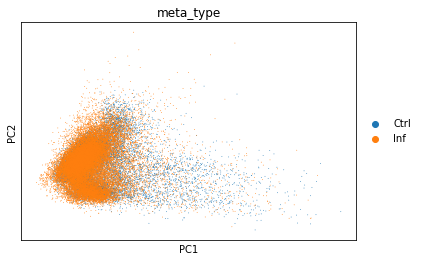

In [292]:
scanpy.pl.pca(adata2, color="meta_type")

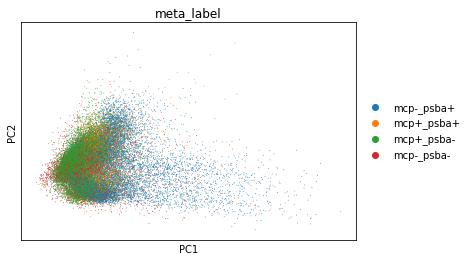

In [293]:
scanpy.pl.pca(adata2, color="meta_label")

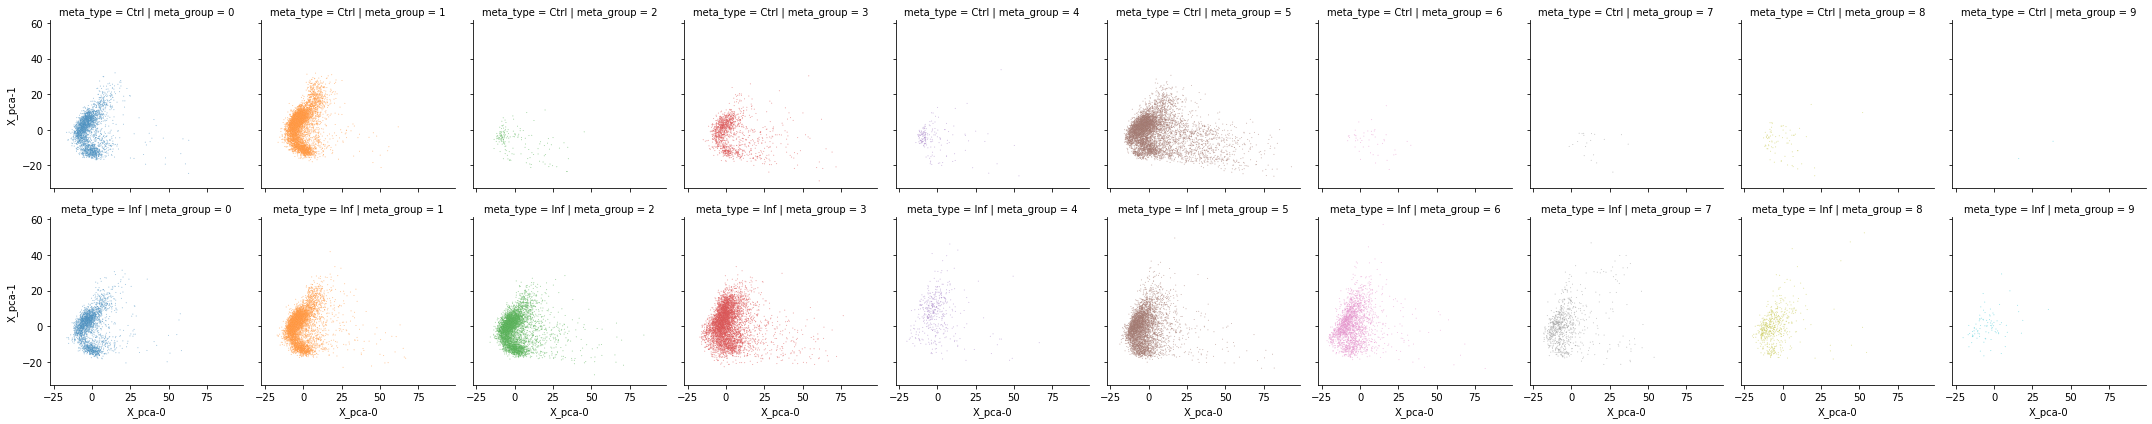

In [294]:
tmp_df = scanpy.get.obs_df(
    adata2,
    keys=["meta_group", "meta_type"],
    obsm_keys=[("X_pca", 0), ("X_pca", 1)]
)

grid = seaborn.FacetGrid(data=tmp_df, row="meta_type", col="meta_group")
grid.map_dataframe(seaborn.scatterplot, x="X_pca-0", y="X_pca-1", hue="meta_group", s=1, alpha=0.5, edgecolors="none")

In [295]:
%%time
scanpy.pp.neighbors(adata2, n_neighbors=20, random_state=0)

scanpy.tl.leiden(adata2, resolution=1.5, random_state=0)

scanpy.tl.paga(adata2)
scanpy.pl.paga(adata2, plot=False, add_pos=True)

scanpy.tl.umap(adata2, min_dist=0.1, init_pos="paga", random_state=0)

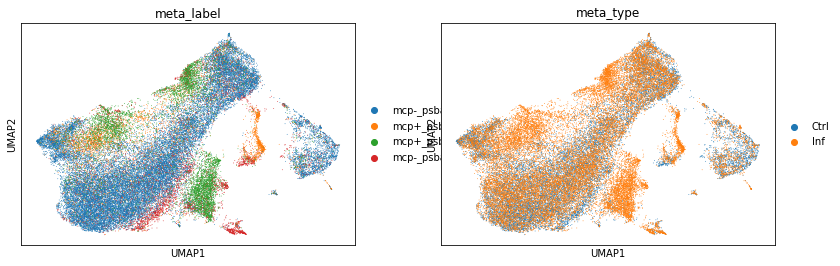

In [296]:
scanpy.pl.umap(adata2, color=['meta_label', 'meta_type'])

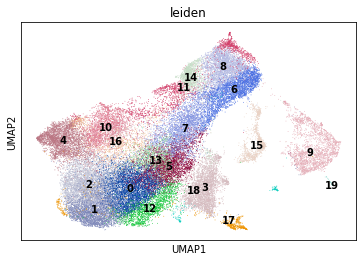

In [332]:
scanpy.pl.umap(adata2, color='leiden', legend_loc='on data')

<AxesSubplot:xlabel='leiden'>

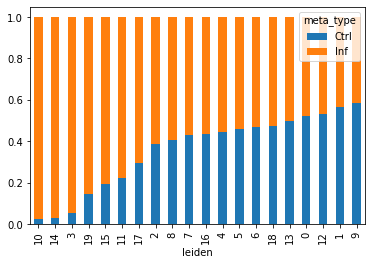

In [298]:
frac_df = (adata2.obs.reset_index(drop=True).groupby(["leiden", "meta_type"]).size() / adata2.obs.groupby("leiden").size()).to_frame(name="frac")
frac_df.reset_index().pivot(index="leiden", columns="meta_type", values="frac").sort_values("Ctrl").plot.bar(stacked=True)

<AxesSubplot:xlabel='leiden'>

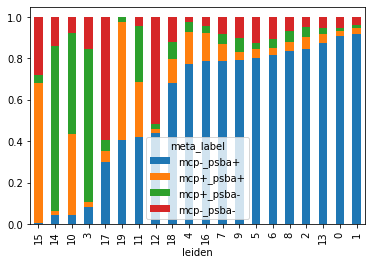

In [299]:
frac_df = (adata2.obs.groupby(["leiden", "meta_label"]).size() / adata2.obs.groupby("leiden").size()).to_frame(name="frac")
frac_df.reset_index().pivot(index="leiden", columns="meta_label", values="frac").sort_values("mcp-_psba+").plot.bar(stacked=True)

In [300]:
maj_label = frac_df.groupby("leiden").idxmax().frac.apply(lambda a: a[1])

In [301]:
adata2.obs["clust_type"] = adata2.obs["leiden"].map(lambda a: maj_label[a]).astype("category")

In [302]:
adata2.obs["clust_id"] = adata2.obs.apply(lambda r: "%s-%s" % (r["clust_type"], r["leiden"]), axis="columns")

In [303]:
"Purity: %.4f" % (adata2.obs.groupby(["leiden", "meta_label"]).size().groupby("leiden").max() / adata2.obs.groupby("leiden").size()).mean()

'Purity: 0.7316'

In [304]:
adata.obsm = adata2.obsm
adata.obs = adata2.obs


AnnData expects .obs.index to contain strings, but got values like:
    [('Ctrl', 21766, 3, nan, 5), ('Ctrl', 19432, 3, nan, 5), ('Ctrl', 16719, 3, nan, 5), ('Ctrl', 19692, 3, nan, 5), ('Ctrl', 17745, 3, nan, 5)]

    Inferred to be: mixed



In [327]:
adata.layers['scaled'] = scanpy.pp.scale(adata, copy=True).X

## Zooming in on structures

### Elevated side-scatter/darkfield signal (potentional stationary cels)

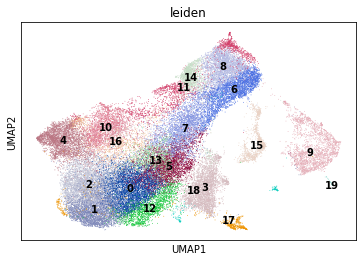

In [305]:
scanpy.pl.umap(adata, color='leiden', legend_loc="on data")

<AxesSubplot:xlabel='leiden', ylabel='feat_bgcorr_max_SSC'>

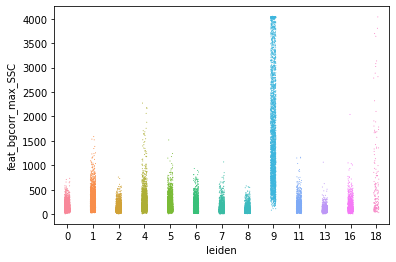

In [306]:
seaborn.stripplot(
    data = scanpy.get.obs_df(adata[adata.obs["clust_type"] == "mcp-_psba+"], keys=["feat_bgcorr_max_SSC", "leiden"]),
    y="feat_bgcorr_max_SSC",
    x="leiden",
    s=1
)

<AxesSubplot:xlabel='leiden', ylabel='count'>

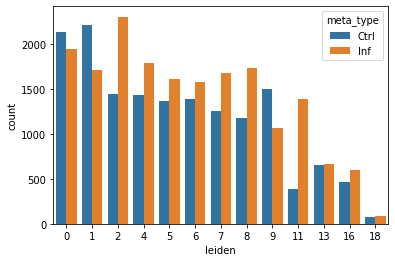

In [307]:
seaborn.countplot(
    data = scanpy.get.obs_df(adata[adata.obs["clust_type"] == "mcp-_psba+"], keys=["meta_type", "leiden"]),
    hue="meta_type",
    x="leiden"
)

In [308]:
tmp_df = scanpy.get.obs_df(adata[adata.obs["clust_type"] == "mcp-_psba+"], keys=["feat_bgcorr_max_SSC", "leiden"])
clusters = tmp_df.groupby("leiden")["feat_bgcorr_max_SSC"].mean().sort_values().index[-1:]
clusters

CategoricalIndex(['9'], categories=['0', '1', '2', '4', '5', '6', '7', '8', ...], ordered=False, dtype='category', name='leiden')

<AxesSubplot:xlabel='leiden', ylabel='count'>

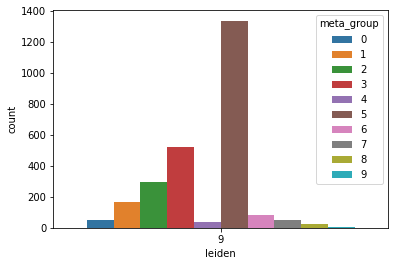

In [309]:
seaborn.countplot(
    data = scanpy.get.obs_df(adata[adata.obs["leiden"].isin(clusters)], keys=["meta_group", "leiden"]),
    hue="meta_group",
    x="leiden"
)

### Dead cells

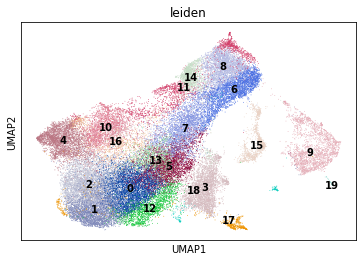

In [310]:
scanpy.pl.umap(adata, color='leiden', legend_loc="on data")

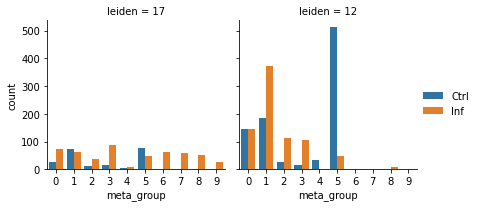

In [311]:
tmp_df = adata2.obs[adata2.obs["clust_type"] == "mcp-_psba-"].copy()
tmp_df["leiden"] = tmp_df["leiden"].astype(str)

grid = seaborn.FacetGrid(data=tmp_df, col="leiden")
grid.map_dataframe(seaborn.countplot, x="meta_group", hue="meta_type", palette="tab10")
grid.add_legend()

Trying to modify attribute `._uns` of view, initializing view as actual.


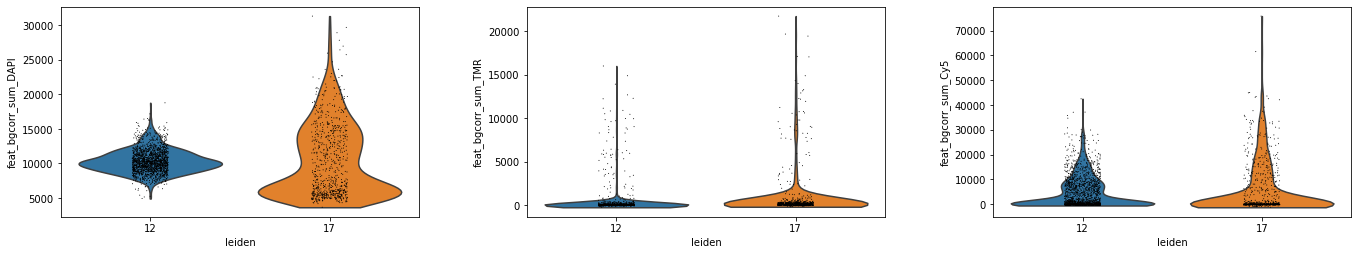

In [314]:
scanpy.pl.violin(adata[adata.obs["clust_type"] == "mcp-_psba-"], keys=["feat_bgcorr_sum_DAPI", "feat_bgcorr_sum_TMR", "feat_bgcorr_sum_Cy5"], groupby="leiden")

#### Explanation full spec

In [338]:
X = adata[adata.obs["clust_type"] == "mcp-_psba-"].to_df()
y = adata[adata.obs["clust_type"] == "mcp-_psba-"].obs["leiden"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

rf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
metrics.balanced_accuracy_score(rf.predict(X_test), y_test)

0.9781873611698158

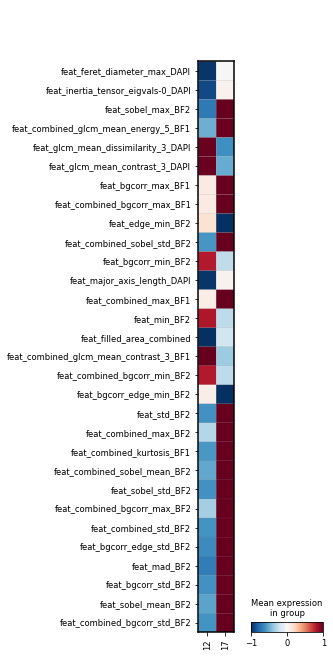

In [340]:
scanpy.pl.matrixplot(
    adata[adata.obs["clust_type"] == "mcp-_psba-"], 
    var_names=X_test.columns[rf.feature_importances_.argsort()[-30:]],
    groupby="leiden",
    layer='scaled', 
    vmin=-1, vmax=1, cmap='RdBu_r',
    swap_axes=True
)

In [462]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)

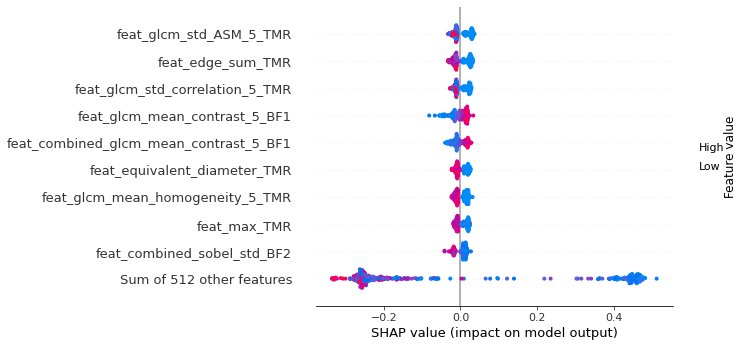

In [463]:
idx = numpy.argsort(shap_values[..., 0].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 0]), order=idx)

In [467]:
%%time
r = permutation_importance(
    rf,
    X_test, y_test, 
    scoring="balanced_accuracy",
    n_jobs=16, n_repeats=10, 
    random_state=0
)

CPU times: user 9.87 s, sys: 55.4 ms, total: 9.92 s
Wall time: 2min 32s


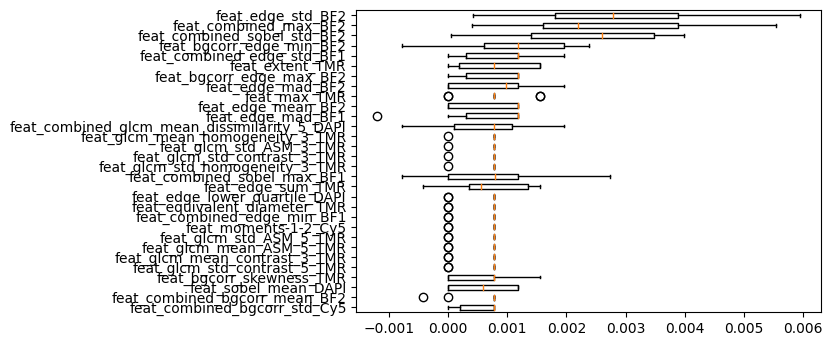

In [468]:
perm_sorted_idx = r.importances_mean.argsort()[-30:]

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    r.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_test.columns[perm_sorted_idx],
);

In [469]:
def func(a):
    i = a.rfind("_")+1
    return a[i:] + "_" + a[:i-1]
sort = numpy.argsort(list(map(func, X_test.columns[perm_sorted_idx])))

In [470]:
var_group = {}
first = {}
for i, v in enumerate(sorted(list(map(lambda a: a.split("_")[-1], X_test.columns[perm_sorted_idx])))):
    var_group[v] = var_group.get(v, 0) + 1
    if v not in first:
        first[v] = i
    
var_group_positions = [(first[k], first[k] + v - 1) for k,v in var_group.items()]

In [471]:
def func(a):
    i = a.rfind("_")
    a = a[len("feat_"):i]
    a = a.replace("_", " ")
    return a
adata.var["friendly_name"] = adata.var_names.map(func)

Trying to modify attribute `.var` of view, initializing view as actual.


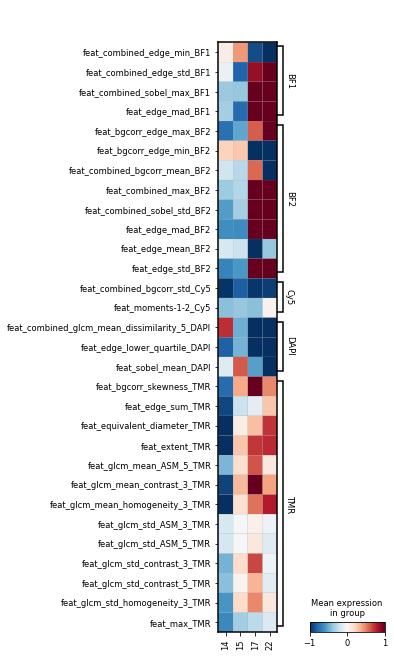

In [474]:
scanpy.pl.matrixplot(
    adata[adata.obs["clust_type"] == "mcp-_psba-"], 
    var_names=X_test.columns[perm_sorted_idx][sort],
    var_group_positions=var_group_positions,
    var_group_labels=list(first.keys()),
    groupby="leiden",
    layer='scaled', 
    vmin=-1, vmax=1, cmap='RdBu_r',
    swap_axes=True
)

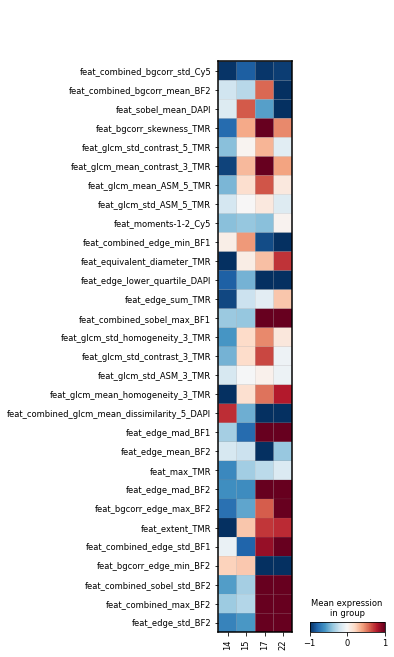

In [476]:
scanpy.pl.matrixplot(
    adata[adata.obs["clust_type"] == "mcp-_psba-"], 
    var_names=X_test.columns[perm_sorted_idx],
    groupby="leiden",
    layer='scaled', 
    vmin=-1, vmax=1, cmap='RdBu_r',
    swap_axes=True
)

#### Explanation reduced spec

In [320]:
X = adata[adata.obs["clust_type"] == "mcp-_psba-", keep].to_df()
y = adata[adata.obs["clust_type"] == "mcp-_psba-", keep].obs["leiden"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, stratify=y)

rf = RandomForestClassifier(n_estimators = 100, oob_score=True).fit(X_train, y_train)
metrics.balanced_accuracy_score(rf.predict(X_test), y_test)

0.9675611589095056

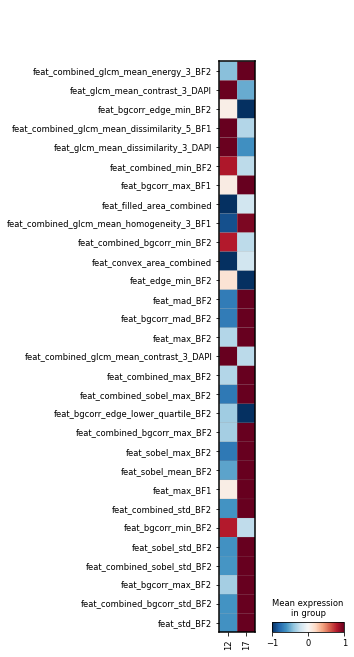

In [329]:
scanpy.pl.matrixplot(
    adata[adata.obs["clust_type"] == "mcp-_psba-"], 
    var_names=X_test.columns[rf.feature_importances_.argsort()[-30:]],
    groupby="leiden",
    layer='scaled', 
    vmin=-1, vmax=1, cmap='RdBu_r',
    swap_axes=True
)

### +/- structures

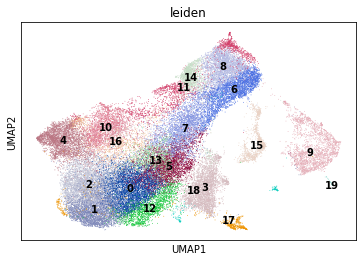

In [330]:
scanpy.pl.umap(adata, color='leiden', legend_loc='on data')

In [331]:
adata.obs[adata.obs.clust_type == "mcp+_psba-"].leiden.unique()

['3', '14', '10']
Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19']

In [479]:
X = adata[adata.obs["clust_type"] == "mcp+_psba-", adata.var.selected_corr].to_df()
y = adata[adata.obs["clust_type"] == "mcp+_psba-", adata.var.selected_corr].obs["leiden"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

rf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
metrics.balanced_accuracy_score(rf.predict(X_test), y_test)

0.9850089435294724

In [480]:
%%time
r = permutation_importance(
    rf,
    X_test, y_test, 
    scoring="balanced_accuracy",
    n_jobs=16, n_repeats=10, 
    random_state=0
)

CPU times: user 9.96 s, sys: 411 ms, total: 10.4 s
Wall time: 3min 8s


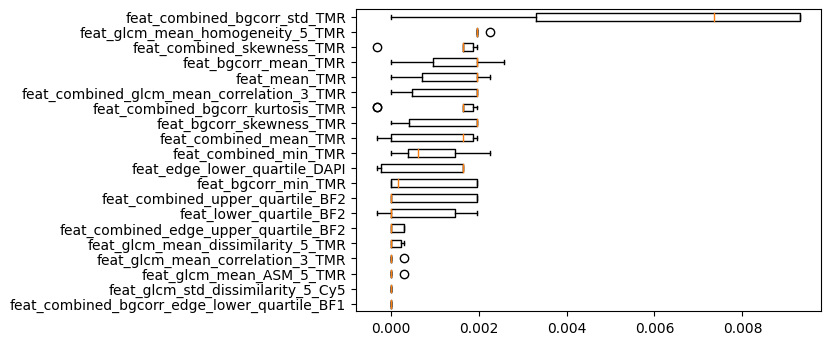

In [484]:
perm_sorted_idx = r.importances_mean.argsort()[-20:]

fig, ax = plt.subplots(1, dpi=100)
ax.boxplot(
    r.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_test.columns[perm_sorted_idx],
);

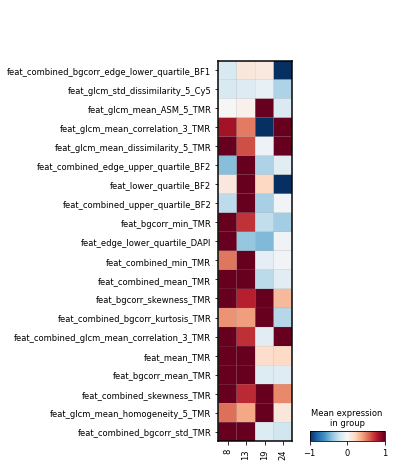

In [485]:
scanpy.pl.matrixplot(
    adata[adata.obs["clust_type"] == "mcp+_psba+"], 
    var_names=X_test.columns[perm_sorted_idx],
    groupby="leiden",
    layer='scaled', 
    vmin=-1, vmax=1, cmap='RdBu_r',
    swap_axes=True
)

### Cell cycle trajectory

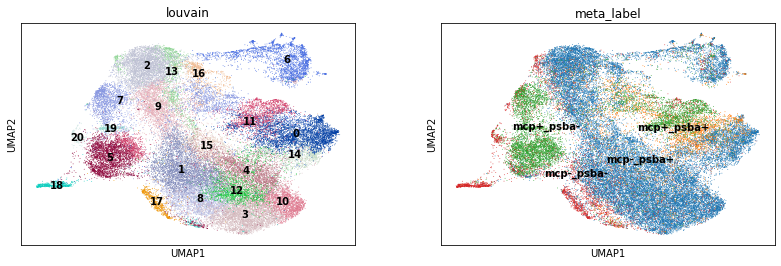

In [250]:
scanpy.pl.umap(adata3, color=["louvain", "meta_label"], legend_loc="on data")

In [260]:
maj_df = frac_df[frac_df.frac > 0.75]
healthy_clust = maj_df[maj_df["meta_label"] == "mcp-_psba+"]["louvain"].tolist()
healthy_clust.remove("6")
adata3.obs["healthy_clust"] = adata3.obs["louvain"].isin(healthy_clust).astype(int)

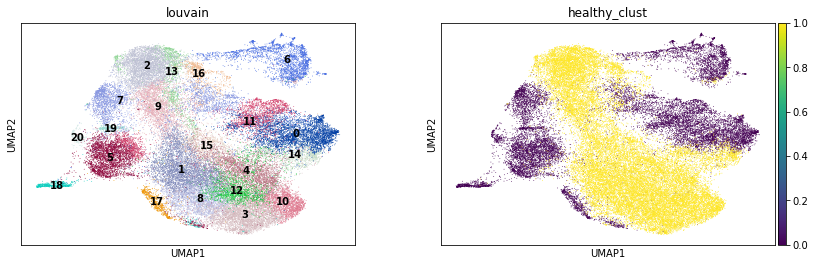

In [261]:
scanpy.pl.umap(adata3, color=["louvain", "healthy_clust"], legend_loc="on data")

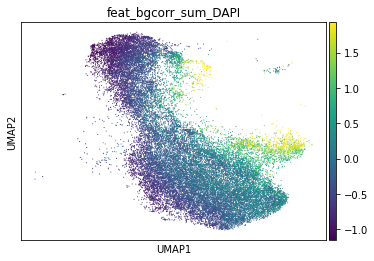

In [268]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_bgcorr_sum_DAPI"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_bgcorr_sum_DAPI"], vmin=qq[0], vmax=qq[1])

All-NaN slice encountered
All-NaN slice encountered


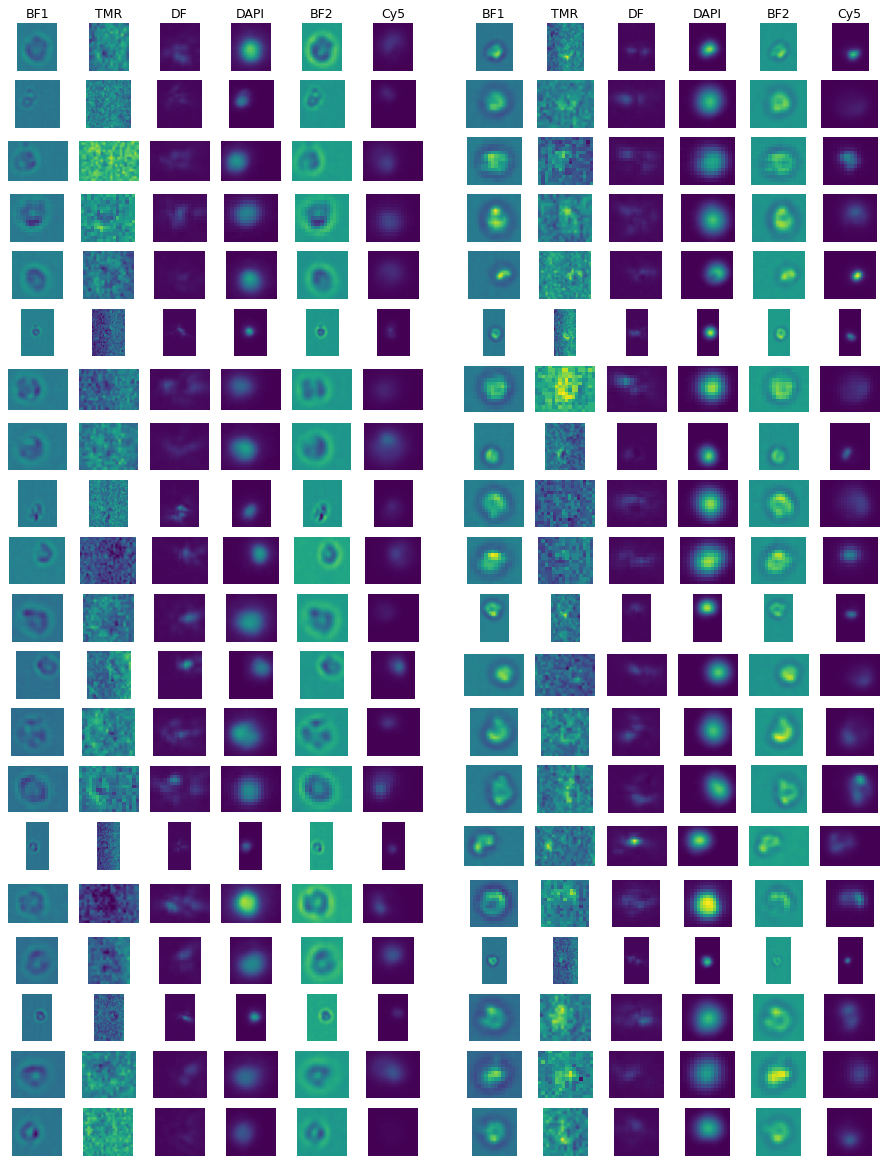

In [157]:
sel_edge_low = sel1 & (df["feat_bgcorr_edge_lower_quartile_BF1"] < -40)
sel_edge_high = sel1 & (df["feat_bgcorr_edge_lower_quartile_BF1"] > 0)
plot_gate_zarr_channels([sel_edge_high, sel_edge_low], df, maxn=20, smooth=1, mask=False, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "DF", "DAPI", "BF2", "Cy5"])

In [278]:
%%time
sel = adata3.obs["louvain"].isin(["2", "3"])
target = adata3.obs["louvain"][sel] == "2"

mi3 = mutual_info_classif(adata3[sel].X, target, n_neighbors=10, random_state=0)
mi3 = pandas.Series(mi3, index=selected_mi).sort_values()
mi3.tail(n=20)

CPU times: user 3.17 s, sys: 882 µs, total: 3.17 s
Wall time: 3.18 s


feat_combined_max_DAPI                     0.416466
feat_combined_edge_std_DAPI                0.423778
feat_bgcorr_max_DAPI                       0.426179
feat_combined_sobel_mean_DAPI              0.426664
feat_bgcorr_upper_quartile_BF1             0.430218
feat_bgcorr_edge_mad_DAPI                  0.471485
feat_combined_median_BF2                   0.477454
feat_combined_std_BF1                      0.527114
feat_combined_upper_quartile_BF2           0.530208
feat_combined_bgcorr_upper_quartile_BF2    0.570493
feat_combined_edge_lower_quartile_BF2      0.592663
feat_bgcorr_mean_BF1                       0.609142
feat_combined_edge_upper_quartile_BF2      0.609818
feat_combined_bgcorr_lower_quartile_BF1    0.647795
feat_edge_upper_quartile_BF2               0.686083
feat_combined_skewness_BF2                 0.686579
feat_bgcorr_edge_upper_quartile_BF2        0.687571
feat_bgcorr_edge_lower_quartile_BF1        0.688259
feat_combined_bgcorr_edge_sum_BF1          0.689560
feat_combine

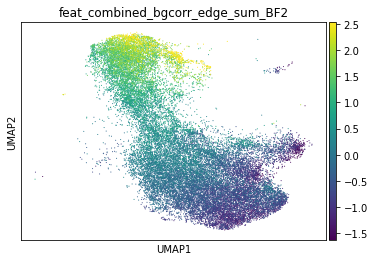

In [279]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_combined_bgcorr_edge_sum_BF2"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_combined_bgcorr_edge_sum_BF2"], vmin=qq[0], vmax=qq[1])

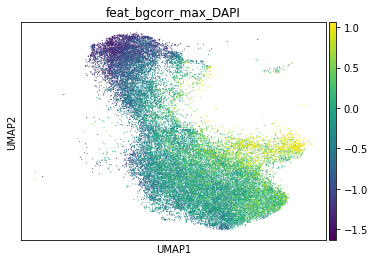

In [280]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_bgcorr_max_DAPI"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_bgcorr_max_DAPI"], vmin=qq[0], vmax=qq[1])

## Trajectory analysis

In [306]:
%%time
scanpy.tl.diffmap(adata3)

CPU times: user 1.54 s, sys: 139 ms, total: 1.68 s
Wall time: 1.7 s


In [314]:
adata3.uns['iroot'] = numpy.flatnonzero(adata3.obs["louvain"] == "2")[0]

In [334]:
scanpy.tl.dpt(adata3, n_branchings=1)

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


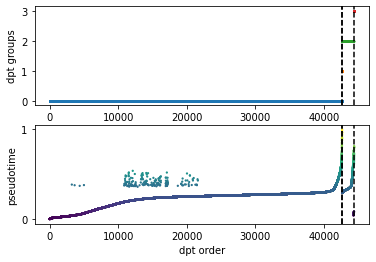

In [336]:
scanpy.pl.dpt_groups_pseudotime(adata3)

In [339]:
adata3.obs["dpt_groups"].unique()

['0', '2', '3', '1']
Categories (4, object): ['0', '1', '2', '3']

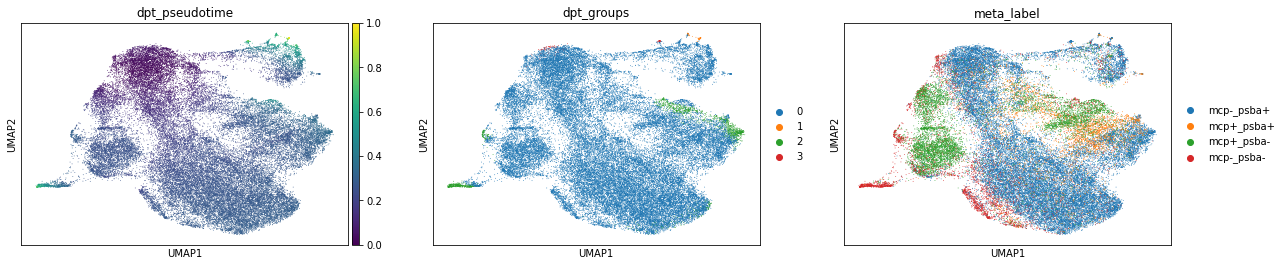

In [340]:
scanpy.pl.umap(adata3, color=["dpt_pseudotime", "dpt_groups", "meta_label"])

## Export

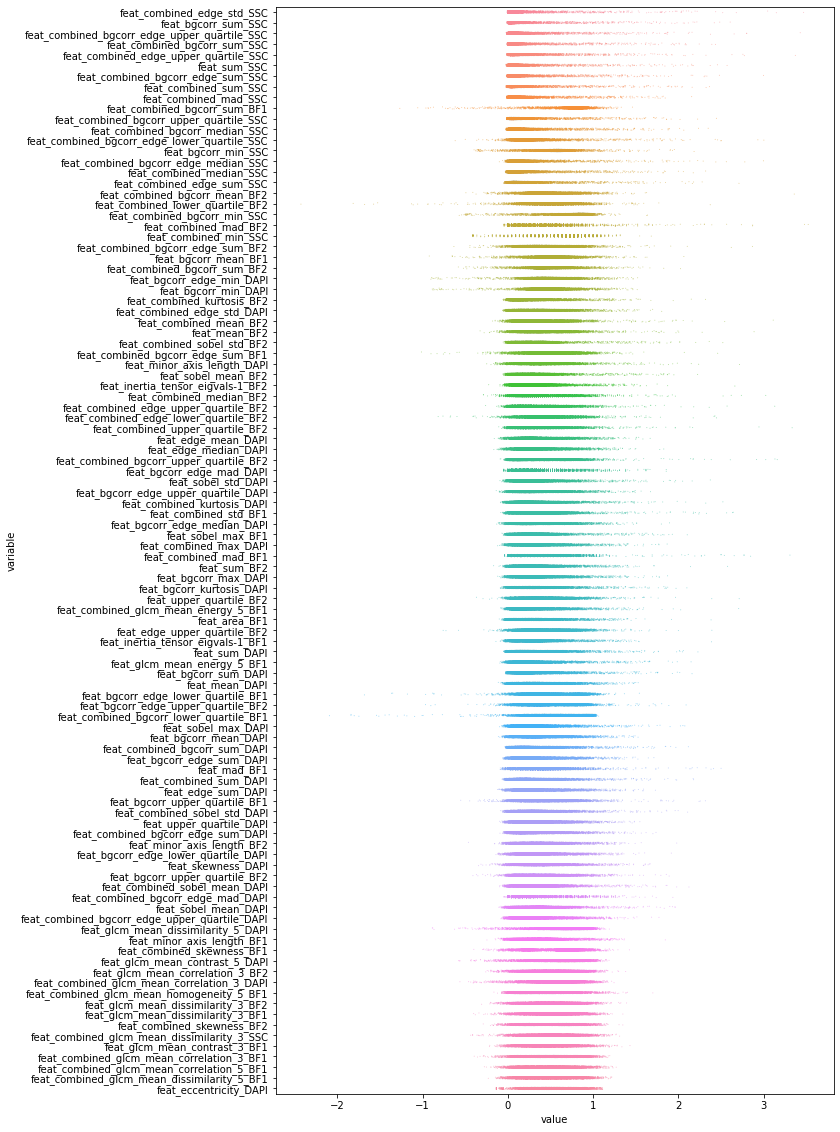

In [115]:
_ = normalization.dists(mm_df[selected_mi])

In [36]:
numpy.save(data_dir / "indices/cluster_index.npy", mm_df[selected_mi][~sel_stationary].index)

In [35]:
df.head()

meta_path  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                                                      
Ctrl      21766              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19432              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          16719              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19692              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          17745              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   

                                                                    meta_zarr_idx  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                  
Ctrl      21766              3              NaN         5                    1000   
          19432              3              NaN         5                    1001   
          16719              3              NaN         5                    1002   
          19692              3              NaN         5                    1003   
          17745              3              NaN         5                    1005   

                                                                    meta_bbox_minr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      3.0   
          19432              3              NaN         5                      3.0   
          16719              3              NaN         5                      1.0   
          19692              3              NaN         5                     12.0   
          17745              3              NaN         5                      0.0   

                                                                    meta_bbox_minc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      8.0   
          19432              3              NaN         5                      6.0   
          16719              3              NaN         5                     10.0   
          19692              3              NaN         5                      7.0   
          17745              3              NaN         5                      2.0   

                                                                    meta_bbox_maxr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     44.0   
          19432              3              NaN         5                     28.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     26.0   
          17745              3              NaN         5                     35.0   

                                                                    meta_bbox_maxc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     31.0   
          19432              3              NaN         5                     23.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     23.0   
          17745              3              NaN         5                     26.0   

                                                                    meta_regions_BF1  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                     
Ctrl      21766              3              NaN         5                   

In [116]:
# flowsom

out_df2 = mm_df[selected_mi][~sel_stationary].copy()
out_df2["meta_label"] = df["meta_label"]
out_df2.reset_index().to_feather(path=data_dir / "cells_scaled.feather")

In [117]:
%%time
pca = PCA(n_components=0.95).fit_transform(mm_df[selected_mi][~sel_stationary])

CPU times: user 454 ms, sys: 34.8 ms, total: 489 ms
Wall time: 491 ms


In [118]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([pca, umap2_[~sel_stationary]]),
    columns=[f"pca_{i}" for i in range(len(pca.T))] + [f"umap_{i}" for i in range(len(umap2_.T))]
)

In [119]:
slingshot_df.to_feather(data_dir / "slingshot.feather")

## Plots

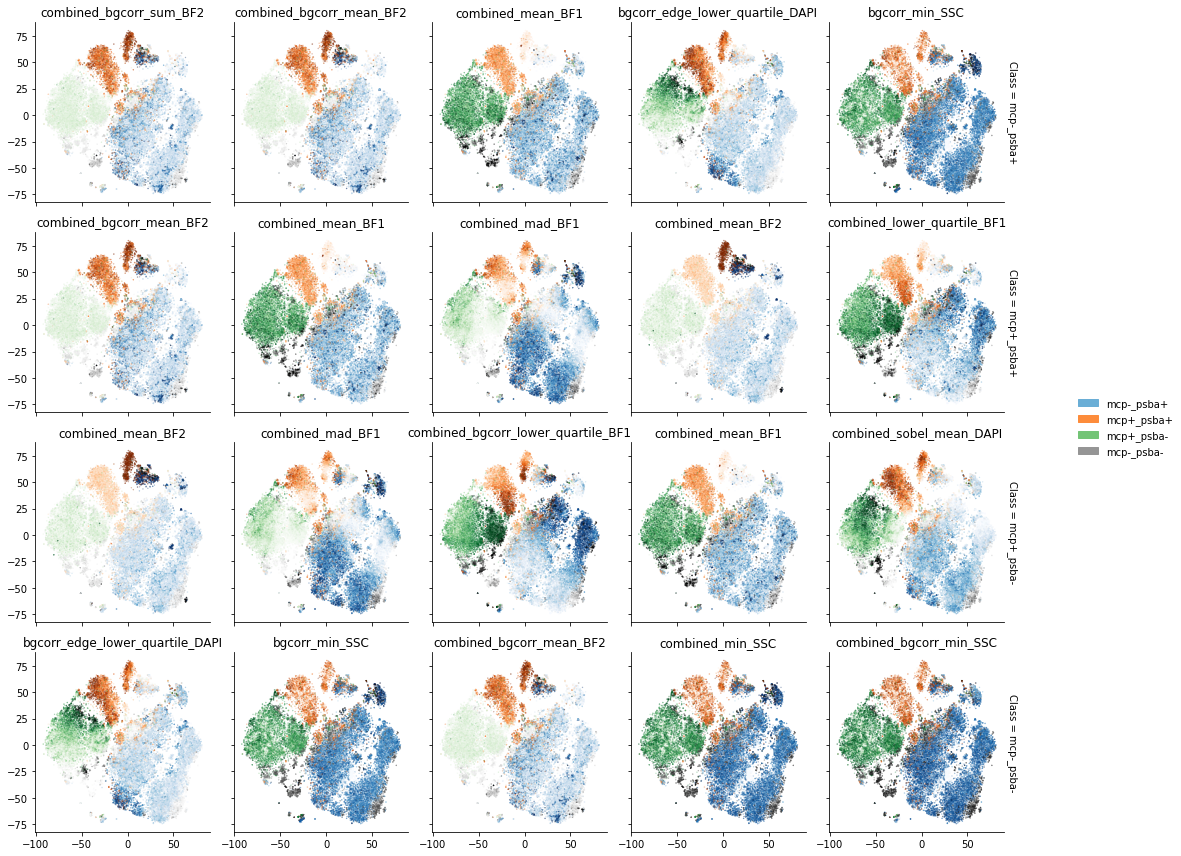

In [106]:
import matplotlib.patches as mpatches

def draw_dimred(data, x, *args, **kwargs):
    f = data[x].iloc[0][len("scip_"):]
    ax = plt.gca()
    norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][f].quantile(0.05), vmax=df.loc["Inf"][f].quantile(0.95))
    
    for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
        sel = df.loc["Inf"]["meta_label"] == cat
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap=cmap, norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)

grid = seaborn.FacetGrid(data=top5, row="Class", col="Rank", margin_titles=True)

legend_data = {}
for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
    legend_data[cat] = mpatches.Patch(color=plt.get_cmap(cmap)(0.5), label=cat)
grid.add_legend(legend_data=legend_data)

grid.map_dataframe(draw_dimred, x="Feature")
for (c, r), ax in grid.axes_dict.items():
    f = top5.set_index(["Class", "Rank"]).loc[c, r]["Feature"]
    ax.set_title(f[len("scip_feat_"):])
    
grid.set_xlabels("")
grid.tight_layout()

plt.savefig(data_dir / "figures/tsne_color_top5_shap.png", bbox_inches="tight", dpi=150)

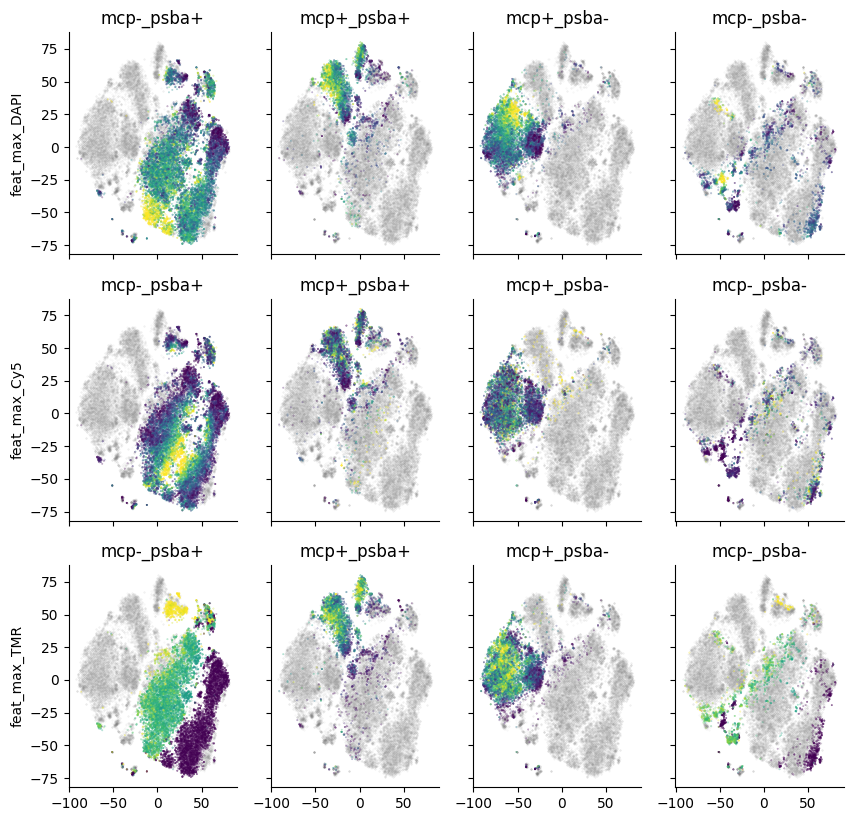

In [107]:
fig, axes = plt.subplots(3, 4, dpi=100, figsize=(10, 10), sharex=True, sharey=True)

for f, row in zip(["feat_max_DAPI", "feat_max_Cy5", "feat_max_TMR"], axes):

    row[0].set_ylabel(f)
    for ax, cat in zip(row, df["meta_label"].cat.categories):
        sel = df.loc["Inf"]["meta_label"] == cat
        norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][sel][f].quantile(0.05), vmax=df.loc["Inf"][sel][f].quantile(0.95))
        ax.scatter(x=tsne[~sel, 0], y=tsne[~sel, 1], c="grey", s=0.1, alpha=0.1)
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap="viridis", norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)
        ax.set_title(cat)

seaborn.despine(fig)

plt.savefig(data_dir / "figures/tsne_color_fluor.png", bbox_inches="tight", dpi=150)

All-NaN slice encountered
All-NaN slice encountered


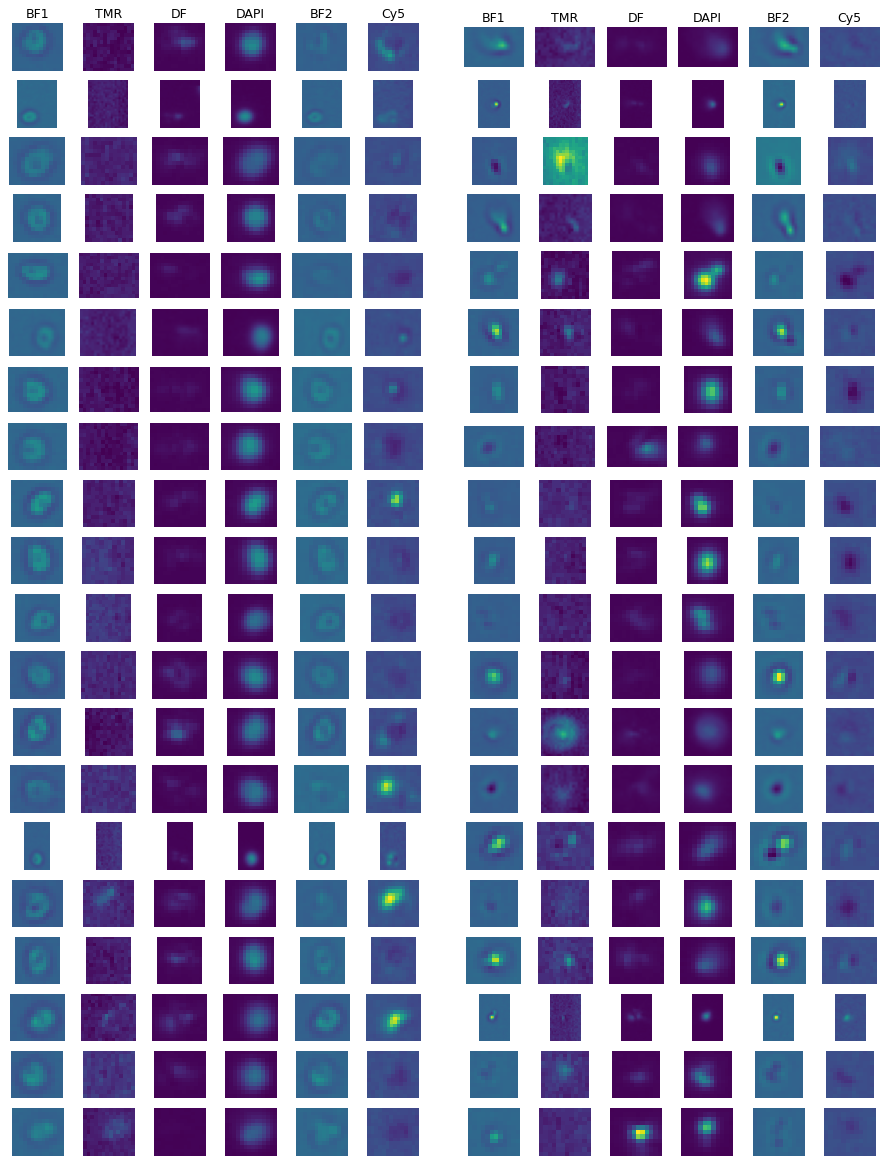

In [117]:
sel_diss_low = (df["feat_combined_glcm_mean_homogeneity_5_BF1"] < 0.25) & sel5
sel_diss_high = (df["feat_combined_glcm_mean_homogeneity_5_BF1"] > .4) & (sel1 | sel2 | sel3)
plot_gate_zarr_channels([sel_diss_low, sel_diss_high], df, maxn=20, smooth=1, mask=False, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "DF", "DAPI", "BF2", "Cy5"])